In [1]:
!pip install findspark

In [1]:
# 1. Refresher: Basic SQL Operations in Spark SQL
import findspark
findspark.init()
from pyspark.sql import SparkSession 

# Membuat Spark session
spark = SparkSession.builder.appName("DataFrameExample").getOrCreate()
data = [
    ('Senandung', 25, 'F', 3500, 1),
    ('Marimby', 28, 'F', 4200, 2),
    ('Wisnu', 34, 'M', 2700, 1),
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

25/10/23 11:44:32 WARN Utils: Your hostname, senandung-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/10/23 11:44:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/23 11:44:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/23 11:44:52 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+---------+---+------+------+------+
|     Name|Age|Gender|Salary|DeptId|
+---------+---+------+------+------+
|Senandung| 25|     F|  3500|     1|
|  Marimby| 28|     F|  4200|     2|
|    Wisnu| 34|     M|  2700|     1|
+---------+---+------+------+------+

+---------+---+
|     Name|Age|
+---------+---+
|Senandung| 25|
|  Marimby| 28|
+---------+---+



[Stage 6:=====>                                                    (1 + 9) / 10]

+------------------+
|       avg(Salary)|
+------------------+
|3466.6666666666665|
+------------------+



In [2]:
# 2. Advanced Queries for Data Analysis
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

[Stage 9:==============================================>           (8 + 2) / 10]

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     F|       3500| 25|
|     F|       4200| 28|
|     M|       2700| 34|
+------+-----------+---+



In [7]:
# a. Cari rata-rata gaji per departemen.
from pyspark.sql import functions as F

avg_salary_dept = df.groupBy("DeptId").agg(F.avg("Salary").alias("AvgSalaryDept"))
avg_salary_dept.show()

[Stage 15:>                                                       (0 + 10) / 10]

+------+-------------+
|DeptId|AvgSalaryDept|
+------+-------------+
|     1|       3100.0|
|     2|       4200.0|
+------+-------------+



In [8]:
# b. Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.
avg_gender = df.groupBy("Gender").agg(F.avg("Salary").alias("AvgSalaryGender"))

above_avg = df.join(avg_gender, on="Gender") \
              .filter(F.col("Salary") > F.col("AvgSalaryGender")) \
              .select("Name", "Gender", "Salary", "AvgSalaryGender")

above_avg.show()

+-------+------+------+---------------+
|   Name|Gender|Salary|AvgSalaryGender|
+-------+------+------+---------------+
|Marimby|     F|  4200|         3850.0|
+-------+------+------+---------------+



In [9]:
# c. Buat ranking karyawan berdasarkan gaji dalam departemen mereka.
from pyspark.sql.window import Window

windowDept = Window.partitionBy("DeptId").orderBy(F.col("Salary").desc())

ranked = df.withColumn("RankInDept", F.rank().over(windowDept))
ranked.show()

[Stage 24:============================>                            (5 + 5) / 10]

+---------+---+------+------+------+----------+
|     Name|Age|Gender|Salary|DeptId|RankInDept|
+---------+---+------+------+------+----------+
|Senandung| 25|     F|  3500|     1|         1|
|    Wisnu| 34|     M|  2700|     1|         2|
|  Marimby| 28|     F|  4200|     2|         1|
+---------+---+------+------+------+----------+



In [5]:
# 3. Penggunaan Window Functions dan Subqueries
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

[Stage 12:=============================================>           (8 + 2) / 10]

+---------+---+------+----+
|     Name|Age|Salary|rank|
+---------+---+------+----+
|Senandung| 25|  3500|   1|
|  Marimby| 28|  4200|   1|
|    Wisnu| 34|  2700|   1|
+---------+---+------+----+



In [10]:
# 4. Advanced Spark SQL Queries
from pyspark.sql import SparkSession

# Membuat SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# === DATAFRAME PEGAWAI ===
employees = spark.createDataFrame([
    ('Senandung', 25, 'F', 3500, 1),
    ('Marimby', 28, 'F', 4200, 2),
    ('Wisnu', 34, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

# === DATAFRAME DEPARTEMEN ===
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

# === DATAFRAME PROYEK ===
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])

# Registrasi ke temporary view untuk SQL
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# === QUERY: JOIN ANTAR TABEL ===
result = spark.sql('''
SELECT e.Name, e.Age, e.Gender, e.Salary, 
       d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''')

result.show()

25/10/23 09:27:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
[Stage 29:===================================================>     (9 + 1) / 10]

+---------+---+------+------+---------+-----------+
|     Name|Age|Gender|Salary| DeptName|ProjectName|
+---------+---+------+------+---------+-----------+
|    Wisnu| 34|     M|  2700|       HR|  Project A|
|Senandung| 25|     F|  3500|       HR|  Project A|
|  Marimby| 28|     F|  4200|Marketing|  Project B|
+---------+---+------+------+---------+-----------+



In [3]:
# a. Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Inisialisasi SparkSession
spark = SparkSession.builder.appName('Tugas5_RataRata_Ranking').getOrCreate()

# Dataframe karyawan
employees = spark.createDataFrame([
    ('Senandung', 25, 'F', 3500, 1),
    ('Marimby', 28, 'F', 4200, 2),
    ('Wisnu', 34, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

# Dataframe departemen
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

# Registrasi temporary view untuk SQL
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')

# === Query SQL untuk menghitung rata-rata dan ranking gaji per departemen ===
query = '''
SELECT 
    e.Name, e.Age, e.Gender, e.Salary, d.DeptName,
    ROUND(AVG(e.Salary) OVER (PARTITION BY e.DeptId), 2) AS Avg_Salary_Per_Dept,
    RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS Salary_Rank
FROM employees e
JOIN departments d
    ON e.DeptId = d.DeptId
ORDER BY d.DeptName, Salary_Rank
'''

# Eksekusi query
result = spark.sql(query)
result.show()

25/10/23 11:45:30 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
[Stage 16:>                                                         (0 + 1) / 1]

+---------+---+------+------+---------+-------------------+-----------+
|     Name|Age|Gender|Salary| DeptName|Avg_Salary_Per_Dept|Salary_Rank|
+---------+---+------+------+---------+-------------------+-----------+
|Senandung| 25|     F|  3500|       HR|             3100.0|          1|
|    Wisnu| 34|     M|  2700|       HR|             3100.0|          2|
|  Marimby| 28|     F|  4200|Marketing|             4200.0|          1|
+---------+---+------+------+---------+-------------------+-----------+



In [4]:
# b. Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Inisialisasi SparkSession
spark = SparkSession.builder.appName('Tugas6_TrenGaji_Usia').getOrCreate()

# Dataframe karyawan
employees = spark.createDataFrame([
    ('Senandung', 25, 'F', 3500, 1),
    ('Marimby', 28, 'F', 4200, 2),
    ('Wisnu', 34, 'M', 2700, 1),
    ('Olivia', 30, 'F', 3900, 2),
    ('Ikhwan', 40, 'M', 5000, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

# Dataframe departemen
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

# Gabungkan kedua dataframe
df = employees.join(departments, on='DeptId')

# Definisikan window berdasarkan DeptId dan diurutkan berdasarkan usia
windowSpec = Window.partitionBy('DeptName').orderBy('Age') \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Hitung tren gaji berdasarkan usia
df_tren = df.withColumn(
    'Cumulative_Avg_Salary',
    F.round(F.avg('Salary').over(windowSpec), 2)
).withColumn(
    'Salary_Trend',
    F.when(F.col('Salary') > F.avg('Salary').over(windowSpec), 'Di atas rata-rata')
     .otherwise('Di bawah rata-rata')
)

# Tampilkan hasil
df_tren.select('Name', 'Age', 'DeptName', 'Salary', 'Cumulative_Avg_Salary', 'Salary_Trend') \
    .orderBy('DeptName', 'Age') \
    .show()

25/10/23 11:45:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
[Stage 21:>                                                         (0 + 1) / 1]

+---------+---+---------+------+---------------------+------------------+
|     Name|Age| DeptName|Salary|Cumulative_Avg_Salary|      Salary_Trend|
+---------+---+---------+------+---------------------+------------------+
|Senandung| 25|       HR|  3500|               3500.0|Di bawah rata-rata|
|    Wisnu| 34|       HR|  2700|               3100.0|Di bawah rata-rata|
|   Ikhwan| 40|       HR|  5000|              3733.33| Di atas rata-rata|
|  Marimby| 28|Marketing|  4200|               4200.0|Di bawah rata-rata|
|   Olivia| 30|Marketing|  3900|               4050.0|Di bawah rata-rata|
+---------+---+---------+------+---------------------+------------------+



   Age  AverageSalary
0   25         3500.0
1   28         4200.0
2   34         2700.0


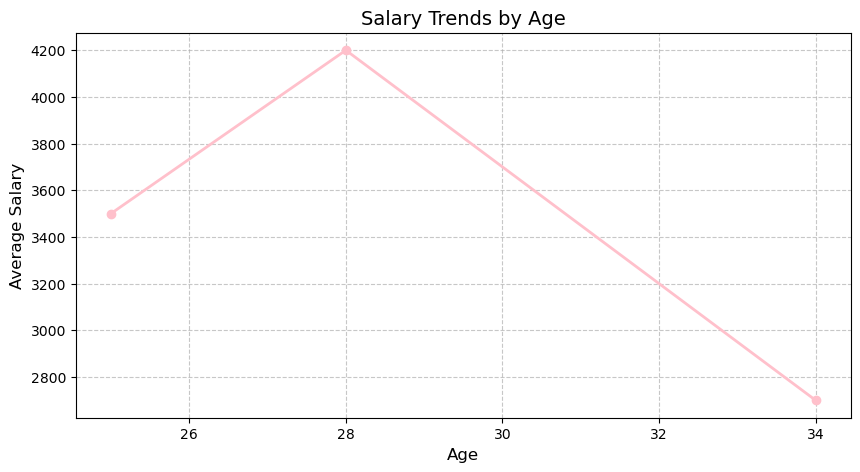

In [8]:
# 5. Advanced Data Analysis and Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Tutup semua figure lama agar tidak muncul ganda
plt.close('all')

salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Cek datanya dulu
print(salary_trends)

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o', color='pink', linewidth=2)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
plt.title('Salary Trends by Age', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
